In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
draft2_path = '2 draft.csv'
draft9_path = '9 draft.csv'
train_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'

train  = pd.read_csv(train_path).rename(columns=clear_cols)
draft2 = pd.read_csv(draft2_path).rename(columns=clear_cols)
draft9 = pd.read_csv(draft9_path).rename(columns=clear_cols)

In [4]:
draft2.sample()

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
298,PRV51380,51000.0,12750.0,560.0,140.0


In [5]:
draft9.sample()

,Provider,IPInscClaimAmtReimbursedCount,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedMax,OPInscClaimAmtReimbursedCount,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedMax
111,PRV51143,0.0,0.0,0.0,77.0,515.694456,3300.0


In [6]:
draft2Provider = draft2['Provider'].nunique()
print(f'Unique provider in draft2: {draft2Provider}, the shape is {draft2.shape}')
draft9Provider = draft9['Provider'].nunique()
print(f'Unique provider in draft9: {draft9Provider}, the shape is {draft9.shape}')


Unique provider in draft2: 5410, the shape is (5410, 5)
Unique provider in draft9: 5410, the shape is (5410, 7)


In [7]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    draft2,  # Left: Provider, IP_Claims_Total
    draft9,  # Right: Provider, OP_Claims_Total
    on='Provider',
    how='left'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [8]:
provider_claims

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed,IPInscClaimAmtReimbursedCount,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedMax,OPInscClaimAmtReimbursedCount,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedMax
0,PRV51001,97000.0,19400.000000,7640.0,382.000000,5.0,18352.111595,42000.0,20.0,422.817617,1500.0
1,PRV51003,573000.0,9241.935484,32670.0,466.714286,62.0,8513.606244,57000.0,70.0,821.364579,3300.0
2,PRV51004,0.0,0.000000,52170.0,350.134228,0.0,0.000000,0.0,149.0,689.963754,3300.0
3,PRV51005,0.0,0.000000,280910.0,241.124464,0.0,0.000000,0.0,1165.0,491.556392,4080.0
4,PRV51007,19000.0,6333.333333,14710.0,213.188406,3.0,3511.884584,10000.0,69.0,447.231657,3300.0
...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,10640.0,380.000000,0.0,0.000000,0.0,28.0,820.880286,3300.0
5406,PRV57760,0.0,0.000000,4770.0,216.818182,0.0,0.000000,0.0,22.0,309.998254,1100.0
5407,PRV57761,0.0,0.000000,18470.0,225.243902,0.0,0.000000,0.0,82.0,418.366092,2200.0
5408,PRV57762,0.0,0.000000,1900.0,1900.000000,0.0,0.000000,0.0,1.0,0.000000,1900.0


In [9]:
provider_claims = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
    )

In [10]:
provider_claims['PotentialFraud'] = provider_claims['PotentialFraud'].map({'Yes': 1, 'No': 0})


In [11]:
provider_claims.columns

Index(['Provider', 'IPTotalInscClaimAmtReimbursed',
       'IPMeanInscClaimAmtReimbursed', 'OPTotalInscClaimAmtReimbursed',
       'OPMeanInscClaimAmtReimbursed', 'IPInscClaimAmtReimbursedCount',
       'IPInscClaimAmtReimbursedStd', 'IPInscClaimAmtReimbursedMax',
       'OPInscClaimAmtReimbursedCount', 'OPInscClaimAmtReimbursedStd',
       'OPInscClaimAmtReimbursedMax', 'PotentialFraud'],
      dtype='object')

In [12]:
X = provider_claims[['IPTotalInscClaimAmtReimbursed',
       'IPMeanInscClaimAmtReimbursed', 'OPTotalInscClaimAmtReimbursed',
       'OPMeanInscClaimAmtReimbursed', 'IPInscClaimAmtReimbursedCount',
       'IPInscClaimAmtReimbursedStd', 'IPInscClaimAmtReimbursedMax',
       'OPInscClaimAmtReimbursedCount', 'OPInscClaimAmtReimbursedStd',
       'OPInscClaimAmtReimbursedMax']]

In [13]:
y = provider_claims['PotentialFraud']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [15]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [16]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [17]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:,1]

In [18]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[961  16]
 [ 62  43]]


In [19]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.93
Precision: 0.73
Recall: 0.41
F1 Score: 0.52


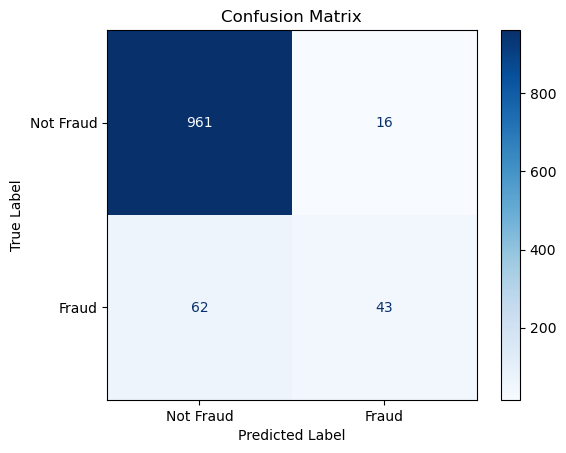

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

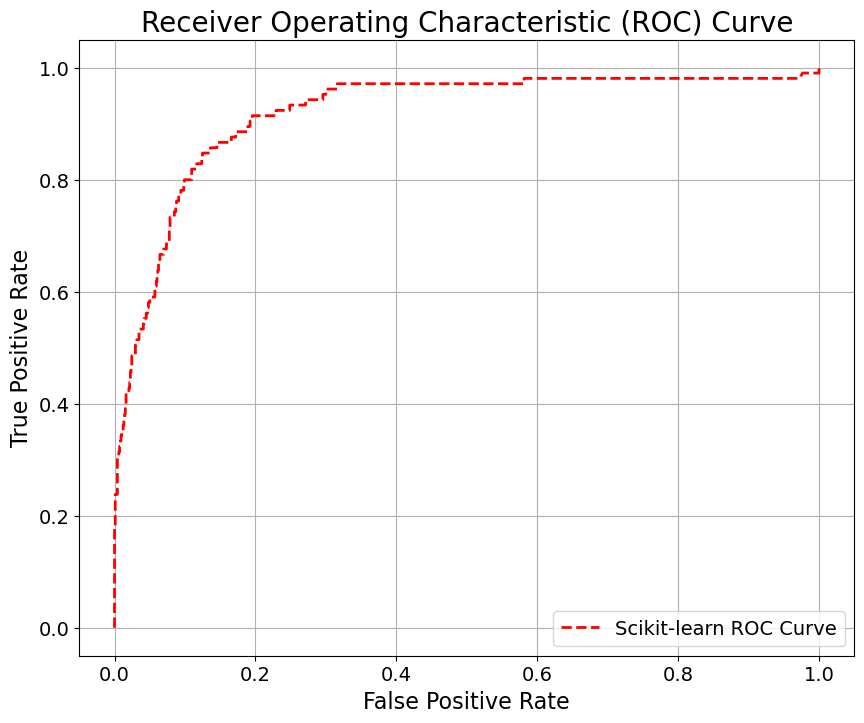

In [21]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [22]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9196861139542819)

In [56]:
# Create a DataFrame with predictions and actual values
roc_df = pd.DataFrame({
    'true_label': y_test.values,
    'pred_prob': y_proba # my guess?
})
roc_df.head(10)

,true_label,pred_prob
0,0,0.015379
1,0,0.014078
2,0,0.014141
3,0,0.027663
4,0,0.720370
5,0,0.019387
6,0,0.014809
7,1,0.954960
8,0,0.025047
9,0,0.024046


In [57]:
# Sort by predicted probability in descending order
roc_df = roc_df.sort_values('pred_prob', ascending=False).reset_index(drop=True)
# Display the first few rows to understand the data
print("Step 1: Sorted predictions by probability")
roc_df.head(10)

Step 1: Sorted predictions by probability


,true_label,pred_prob
0,1,1.000000
1,1,0.999994
2,1,0.999993
3,1,0.999687
4,1,0.998887
5,1,0.998199
6,1,0.998037
7,1,0.997029
8,1,0.997009
9,1,0.996507


In [58]:
# Step 2: Calculate TPR and FPR at each possible threshold
# Initialize columns for counts and rates
roc_df['threshold'] = roc_df['pred_prob']  # Each row's probability becomes a potential threshold
roc_df['TP'] = 0
roc_df['FP'] = 0
roc_df['FN'] = 0
roc_df['TN'] = 0
roc_df['TPR'] = 0.0
roc_df['FPR'] = 0.0

In [59]:
roc_df.head(10)

,true_label,pred_prob,threshold,TP,FP,FN,TN,TPR,FPR
0,1,1.000000,1.000000,0,0,0,0,0.0,0.0
1,1,0.999994,0.999994,0,0,0,0,0.0,0.0
2,1,0.999993,0.999993,0,0,0,0,0.0,0.0
3,1,0.999687,0.999687,0,0,0,0,0.0,0.0
4,1,0.998887,0.998887,0,0,0,0,0.0,0.0
5,1,0.998199,0.998199,0,0,0,0,0.0,0.0
6,1,0.998037,0.998037,0,0,0,0,0.0,0.0
7,1,0.997029,0.997029,0,0,0,0,0.0,0.0
8,1,0.997009,0.997009,0,0,0,0,0.0,0.0
9,1,0.996507,0.996507,0,0,0,0,0.0,0.0


In [60]:
# Calculate actual counts of positives and negatives
n_pos = sum(roc_df['true_label'] == 1)
n_neg = sum(roc_df['true_label'] == 0)
print(f"Total positive examples (fruad = fraud): {n_pos}")
print(f"Total negative examples: {n_neg}")

Total positive examples (fruad = fraud): 105
Total negative examples: 977


In [61]:
# Step 3: For each threshold (row in our sorted df), calculate confusion matrix values
for i in range(len(roc_df)):
    # At this threshold, predictions for indices >= i are positive
    # and predictions for indices < i are negative
    threshold = roc_df.loc[i, 'threshold']
    # Calculate TP, FP, FN, TN for this threshold
    preds = (roc_df['pred_prob'] >= threshold).astype(int)
    TP = sum((preds == 1) & (roc_df['true_label'] == 1))
    FP = sum((preds == 1) & (roc_df['true_label'] == 0))
    FN = sum((preds == 0) & (roc_df['true_label'] == 1))
    TN = sum((preds == 0) & (roc_df['true_label'] == 0))
    # Calculate TPR and FPR
    TPR = TP / n_pos if n_pos > 0 else 0
    FPR = FP / n_neg if n_neg > 0 else 0
    # Store values
    roc_df.loc[i, 'TP'] = TP
    roc_df.loc[i, 'FP'] = FP
    roc_df.loc[i, 'FN'] = FN
    roc_df.loc[i, 'TN'] = TN
    roc_df.loc[i, 'TPR'] = TPR
    roc_df.loc[i, 'FPR'] = FPR

In [62]:
roc_df

,true_label,pred_prob,threshold,TP,FP,FN,TN,TPR,FPR
0,1,9.999999e-01,9.999999e-01,1,0,104,977,0.009524,0.000000
1,1,9.999943e-01,9.999943e-01,2,0,103,977,0.019048,0.000000
2,1,9.999931e-01,9.999931e-01,3,0,102,977,0.028571,0.000000
3,1,9.996868e-01,9.996868e-01,4,0,101,977,0.038095,0.000000
4,1,9.988866e-01,9.988866e-01,5,0,100,977,0.047619,0.000000
...,...,...,...,...,...,...,...,...,...
1077,0,1.066169e-02,1.066169e-02,104,974,1,3,0.990476,0.996929
1078,0,8.043230e-03,8.043230e-03,104,975,1,2,0.990476,0.997953
1079,0,3.737483e-03,3.737483e-03,104,976,1,1,0.990476,0.998976
1080,0,1.727202e-03,1.727202e-03,104,977,1,0,0.990476,1.000000


In [63]:
# Step 4: Add the (0,0) point explicitly for plotting
roc_points = roc_df[['FPR', 'TPR']].copy()
roc_points.head(5)

,FPR,TPR
0,0.0,0.009524
1,0.0,0.019048
2,0.0,0.028571
3,0.0,0.038095
4,0.0,0.047619


In [64]:
# Add the (0,0) point - when threshold > max probability
roc_points.loc[-1] = [0, 0]
roc_points

,FPR,TPR
0,0.000000,0.009524
1,0.000000,0.019048
2,0.000000,0.028571
3,0.000000,0.038095
4,0.000000,0.047619
...,...,...
1078,0.997953,0.990476
1079,0.998976,0.990476
1080,1.000000,0.990476
1081,1.000000,1.000000


In [65]:
roc_points = roc_points.sort_index().reset_index(drop=True)
roc_points

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.009524
2,0.000000,0.019048
3,0.000000,0.028571
4,0.000000,0.038095
...,...,...
1078,0.996929,0.990476
1079,0.997953,0.990476
1080,0.998976,0.990476
1081,1.000000,0.990476


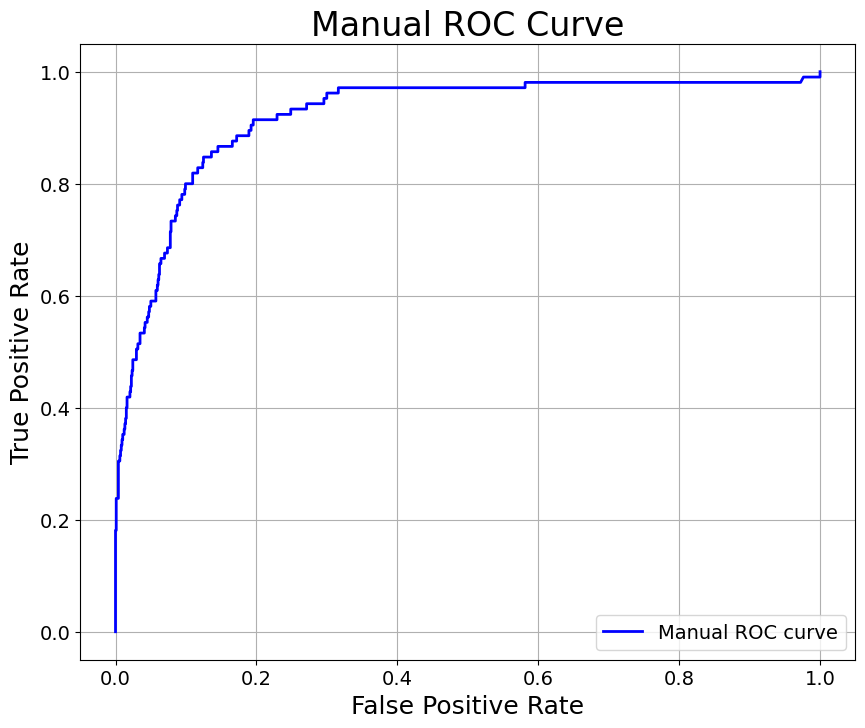

In [66]:
# Step 5: Plot the manually calculated ROC curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(roc_points['FPR'], roc_points['TPR'], 'b-', lw=2, label='Manual ROC curve')
# Set title with larger font size
ax.set_title('Manual ROC Curve', fontsize=24)
# Set axis labels with custom font sizes
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
# Set tick label sizes
ax.tick_params(axis='both', which='major', labelsize=14)
# Set legend font size
ax.legend(fontsize=14)
ax.grid(True)
plt.show()


### loooking for a better threshold to find better f1 score:

In [23]:
# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

In [24]:
precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.11362741827799014


In [25]:
# apply the new best threshold to the predicted probabilities
y_pred_custom = (y_proba >= best_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[900  77]
 [ 28  77]]


In [26]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.90
Precision: 0.50
Recall: 0.73
F1 Score: 0.59


In [32]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc_score:.5f}")

ROC AUC Score: 0.91969
